# Robot Perception

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

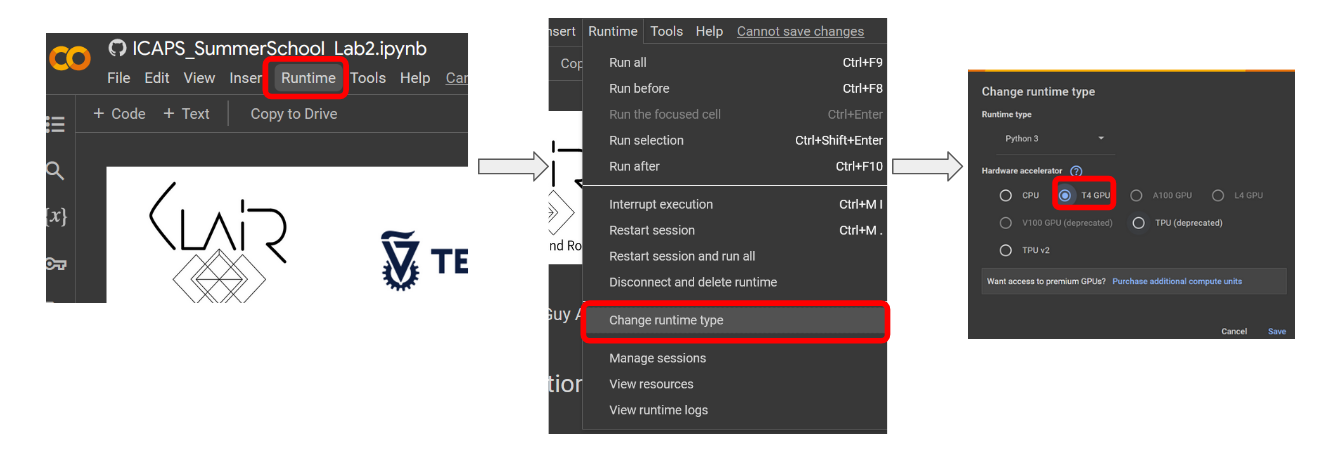

Up until now, we used the simulation to extract exact information about the system's state. However, in real-world scenarios, robots use sensors to perceive their environment. These sensors provide raw numeric data according to what they measure. The agent must interpret this data to understand the state of the environment. This process is known as state estimation: translation from sensor space to task space.

In this tutorial, we will use a visual sensor, i.e., a camera, to perceive the physical location of the red box. We will use basic computer vision techniques to extract an approximate position of the box from RGB and depth images and use these approximations to update our belief of where the box is truly located in the environment.

# Setup

In [1]:
# install required packages
!pip install mujoco
!pip install mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

# Enable GPU rendering in Colab
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU.\n'
    'Make sure you are using a GPU Colab runtime.\n'
    'Go to the Runtime menu and select Choose runtime type.\n'
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)
  
# Set the EGL backend for MuJoCo
import platform

is_apple_silicon = platform.system() == "Darwin" and platform.processor() == "arm"
if not is_apple_silicon:
  %env MUJOCO_GL=egl

Cannot communicate with GPU.
Make sure you are using a GPU Colab runtime.
Go to the Runtime menu and select Choose runtime type.
You can also skip this and use CPU with slower rendering.


## Detecting in Camera Space

Let's revisit our working environment from the previous tutorials. This time, let's use MuJoCo's keyframe feature so that the robot is initialized at the home position, giving us a clean view of the workspace. We will use the "frontview" camera as our sensor, which, given the robot's current configuration, offers a clean view of the red box.

fatal: destination path 'mujoco_menagerie' already exists and is not an empty directory.
UR5e robot MJCF path: mujoco_menagerie/universal_robots_ur5e/ur5e.xml

rendering all available viewpoints



""

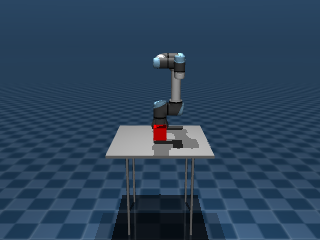

In [2]:
!git clone https://github.com/google-deepmind/mujoco_menagerie
(robot_path,) = !find mujoco_menagerie -name "ur5e.xml"
print(f"UR5e robot MJCF path: {robot_path}\n")

xml = """
<mujoco model="tableworld">
    <statistic center="0.3 0 0.4" extent="0.8"/>

    <visual>
        <headlight diffuse="0.6 0.6 0.6" ambient="0.1 0.1 0.1" specular="0 0 0"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <global azimuth="45" elevation="-20"/>
    </visual>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
                 markrgb="0.8 0.8 0.8" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
    </asset>

    <worldbody>
        <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
        <geom name="floor" pos="0.0 0.0 0.0" size="0 0 0.05" type="plane" material="groundplane"/>

        <body name="table" pos="0.3 0.0 0">
            <geom name="table_top" type="box" size=".37 .37 .01" pos="0 0 .7"/>
            <geom name="table_leg_1" type="cylinder" size=".01 .7" pos=".24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_2" type="cylinder" size=".01 .7" pos=".24 .24 -.0" euler="0 0 0"/>
            <geom name="table_leg_3" type="cylinder" size=".01 .7" pos="-.24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_4" type="cylinder" size=".01 .7" pos="-.24 .24 -.0" euler="0 0 0"/>
        </body>

        <body name="red_box" pos="0.3 0 0.76" quat="0. 0. 1. 0.">
            <freejoint/>
            <geom type="box" size=".05 .05 .05" rgba="1 0 0 1"/>
        </body>

        <!--angle view-->
        <camera name="rightangleview" pos="2.182 1.724 2.590" xyaxes="-0.685 0.729 0.000 -0.456 -0.429 0.780"/>
        <camera name="leftangleview" pos="2.182 -1.724 2.590" xyaxes="0.685 0.729 0.000 -0.456 0.429 0.780"/>
        <!-- front view -->
        <camera mode="fixed" name="frontview" pos="2.5 0 1.45" quat="0.56 0.43 0.43 0.56"/>
        <!-- bird view -->
        <camera mode="fixed" name="birdview" pos="0.3 0 3.0" quat="0.7071 0 0 0.7071"/>
        <!-- side view -->
        <camera mode="fixed" name="leftsideview" pos="0.151 -2.941 0.9" xyaxes="1.000 0.000 0.000 0.000 0.000 1.000"/>
        <camera mode="fixed" name="rightsideview" pos="0.151 2.941 0.9" xyaxes="-1.000 0.000 0.000 0.000 0.000 1.000"/>


    </worldbody>

</mujoco>
"""

import mujoco
import mediapy as media

CHOSEN_CAMERA = "frontview"

scene_spec = mujoco.MjSpec.from_string(xml)
robot_spec = mujoco.MjSpec.from_file(robot_path)

# create a mount (body + site) in the parent where the robot should attach
mount = scene_spec.worldbody.add_body(name="mount", pos=[0.0, 0.0, 0.72], xyaxes=[0, -1, 0, 1, 0, 0])
mount_site = mount.add_site(name="mount_site", pos=[0, 0, 0])

# attach the entire robot spec to the parent's mount site (prefix renames attached elements)
scene_spec.attach(robot_spec, site=mount_site, prefix="")

# compile into a model and data
model = scene_spec.compile()
data = mujoco.MjData(model)

HOME_KEYFRAME_ID = model.key('home').id

mujoco.mj_resetDataKeyframe(model, data, HOME_KEYFRAME_ID)

print('rendering all available viewpoints\n')

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)

    renderer.update_scene(data, camera=CHOSEN_CAMERA)
    image = renderer.render()
    media.show_image(image)

Now we ask: what sets the red box apart from the scene? We want to choose the simplest characteristic we can find that will hold true in most situations. In this case, the red color of the box is a good candidate.

### Pure Color Detection

We can use color thresholding to isolate the red pixels in the RGB image captured by the camera. In RGB, pure red is represented as (255, 0, 0). Let's try to isolate the red pixels:

number of pure red pixels: 1
Pure red image mask


""

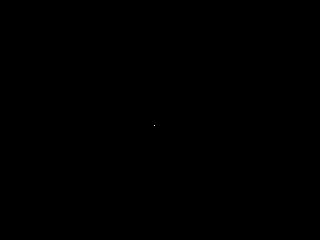

Indicating pure red pixels in green on the original image


""

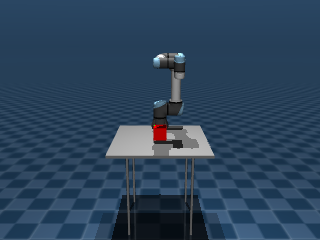

In [3]:
import numpy as np

# pure red color in RGB
pure_red = np.array([255, 0, 0])

# create a mask where pixels matching pure red are True
pure_red_mask = np.all(image == pure_red, axis=-1)

num_pure_red_pixels = np.sum(pure_red_mask)
print(f'number of pure red pixels: {num_pure_red_pixels}')

print("Pure red image mask")
media.show_image(pure_red_mask)

print("Indicating pure red pixels in green on the original image")
indicator_image = image.copy()
indicator_image[pure_red_mask] = [0, 255, 0]
media.show_image(indicator_image)

As we can see, there is exactly one purely red pixel in the image, and it is found in the corner of the box, as is indicated by the green dot in the image. Knowing the dimensions of the box, we could likely infer the center of the box. However, remember that as the scene changes, the color of the box may be perceived differently due to changing lighting conditions. Therefore, a pure red pixel is not sufficient to detect the box. We must allow for some tolerance in our color matching.

### RGB Color Range

Let's try to isolate all pixels that are "red enough." We can define a range of RGB values that we consider to be red. Let's look at some shades of red:

bright red


""

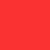

medium red


""

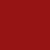

dark red


""

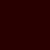

In [4]:
bright_red = [250, 50, 50]
medium_red = [150, 20, 20]
dark_red = [40, 0, 0]

# create a 10x10 image for each shade
bright_red_image = np.full((50, 50, 3), bright_red, dtype=np.uint8)
medium_red_image = np.full((50, 50, 3), medium_red, dtype=np.uint8)
dark_red_image = np.full((50, 50, 3), dark_red, dtype=np.uint8)

print("bright red")
media.show_image(bright_red_image)
print("medium red")
media.show_image(medium_red_image)
print("dark red")
media.show_image(dark_red_image)

As we can see, different shades of RGB can have a big range of red values and a smaller range of green and blue values. Let's create a threshold using these values we just found:

In [5]:
red_rgb_low = np.array([40, 0, 0])
red_rgb_high = np.array([255, 50, 50])

To isolate the red pixels, we can create a mask that includes all pixels within this RGB range. For this, we will use the [OpenCV](https://opencv.org) package which provides a suite of open-source computer vision tools.

In [6]:
!pip install opencv-python

OpenCV provides the `inRange` function, which allows us to create a binary mask based on the defined color range.

```python

Pure red image mask


""

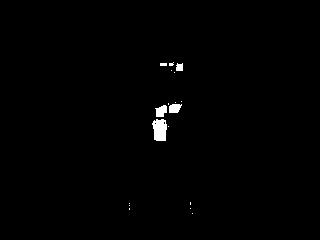

Indicating pure red pixels in green on the original image


""

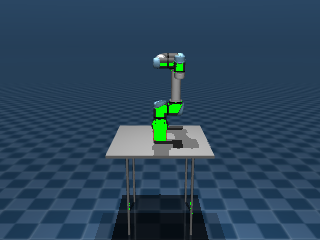

In [7]:
import cv2  # import openCV

# inRange returns a grayscale image with black pixels (0) for pixels outside the range
# and white pixels (255) for pixels inside the range.
red_rgb_range_mask = cv2.inRange(image, red_rgb_low, red_rgb_high) == 255

print("Pure red image mask")
media.show_image(red_rgb_range_mask)

print("Indicating pure red pixels in green on the original image")
indicator_image = image.copy()
indicator_image[red_rgb_range_mask] = [0, 255, 0]
media.show_image(indicator_image)



Our RGB range captures the entire box, but also a big chunk of the robot. Why does this happen? Let's see what colors are captured in our range:

In [8]:
from ipywidgets import interact

@interact(R=(40, 255), G=(0, 50), B=(0, 50))
def render_color(R, G, B):
    color_image = np.full((50, 50, 3), [R, G, B], dtype=np.uint8)
    media.show_image(color_image)

interactive(children=(IntSlider(value=147, description='R', max=255, min=40), IntSlider(value=25, description=…

Playing around with the sliders above, we can actually create dark shades of green, purple, and gray that fall within our defined red range. The problem In the RGB model is that a color is defined by how much Red, Green, and Blue light it has, so a shadow or a bright light changes all three of these values dramatically. Enter HSV.

### HSV Color Range

![hsv](https://docs.opencv.org/4.x/Threshold_inRange_HSV_colorspace.jpg) ![rgb](https://docs.opencv.org/4.x/Threshold_inRange_RGB_colorspace.jpg)

In HSV space, which stands for Hue, Saturation, and Value, one can specify the color (hue) separately from its brightness (value) and intensity (saturation). This makes it much easier to define a color range that is robust to lighting changes.

Pure red image mask


""

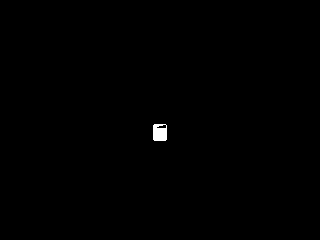

Indicating pure red pixels in green on the original image


""

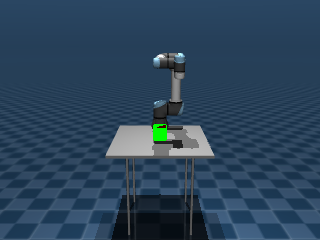

In [9]:
red_hsv_low = np.array([0, 120, 70])
red_hsv_high = np.array([10, 255, 255])

image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)


# inRange returns a grayscale image with black pixels (0) for pixels outside the range
# and white pixels (255) for pixels inside the range.
red_hsv_range_mask = cv2.inRange(image_hsv, red_hsv_low, red_hsv_high) == 255

print("Pure red image mask")
media.show_image(red_hsv_range_mask)

print("Indicating pure red pixels in green on the original image")
indicator_image = image.copy()
indicator_image[red_hsv_range_mask] = [0, 255, 0]
media.show_image(indicator_image)

Much better! We can now find the pixels in the RGB images that are associated with the red box. Let's get their pixel coordinates:

In [10]:
#NOTE: numpy matrices use (row, column) = (y, x) indexing
v, u = np.where(red_hsv_range_mask)
u, v

(array([154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 166, 153, 154, 155,
        156, 157, 158, 166, 153, 154, 155, 156, 166, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 153, 154, 155

## Converting to World Space

When we implemented our controller, we had to translate the configuration of the robot to the end-effector's position in 3D space. Similarly, we now need to convert the pixel coordinates of the detected red box into 3D world coordinates.

### Projecting to the Image Plane

Let's begin by understanding how the camera captures the scene. The camera projects 3D points in the world onto a 2D image plane. This consists of two transformations. The first transformation is the projection from 3D world coordinates to 3D camera coordinates, that is, the coordinates relative to the camera's position and orientation. To do this, we need to know the camera's extrinsic parameters, which include its position and orientation in the world, denoted $t$ and $R$, respectively. Given a point $(x, y, z)$ in the world:
$$
\begin{bmatrix} x_{cam} \\ y_{cam} \\ z_{cam} \end{bmatrix} = R \begin{bmatrix} x \\ y \\ z \end{bmatrix} + t
$$
The second transformation is the projection from 3D camera coordinates to 2D pixel coordinates on the image plane. This transformation uses the camera's intrinsic parameter matrix
$$
K = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
$$
where $f_x$ and $f_y$ are the focal lengths in pixels (distance from the pinhole to the image plane, relative to pixel size), and $(c_x, c_y)$ is the principal point (usually the center of the image), corresponding to where the pinhole is located. Given a point $(x_{cam}, y_{cam}, z_{cam})$ in camera coordinates, the pixel coordinates $(u, v)$ can be computed as:
$$
\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \frac{1}{z_{cam}} K \begin{bmatrix} x_{cam} \\ y_{cam} \\ z_{cam} \end{bmatrix}
$$

![camera projection](https://files.readme.io/88bd3d5-eadda0a-Group_19_2.webp)

### Projecting to Camera Space

We want to invet this process to go from pixel coordinates back to world coordinates. First, to go from pixel coordinates to camera coordinates, we can rearrange the second equation:
$$
\begin{bmatrix} x_{cam} \\ y_{cam} \\ z_{cam} \end{bmatrix} = z_{cam} K^{-1} \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = z_{cam} \begin{bmatrix} (u - c_x) / f_x \\ (v - c_y) / f_y \\ 1 \end{bmatrix}
$$

To find $z_{cam}$, we can use the depth image captured by the camera. Depth cameras use two lenses to estimate the distance of each pixel from the camera. We simulate this by rendering a depth image in MuJoCo.

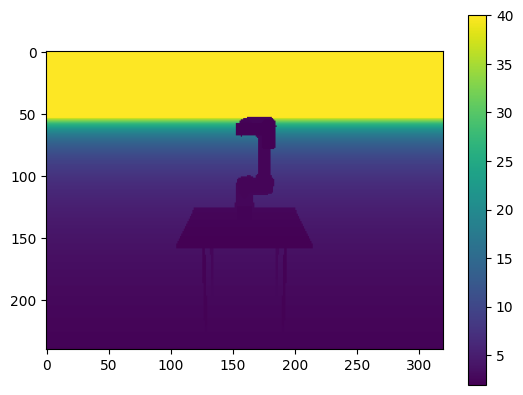

In [11]:
import matplotlib.pyplot as plt

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)

    # change the rendering to depth
    renderer.enable_depth_rendering()

    renderer.update_scene(data, camera=CHOSEN_CAMERA)
    depth_image = renderer.render()

# plot the image as a heatmap
plt.imshow(depth_image, cmap='viridis')
plt.colorbar()
plt.show()

Sanity check: The box is directly in front of the camera, so let's check that the average depth value we get from the depth image approximately matches the distance from the camera to the box in the simulation.

In [12]:
cam_pos = model.camera(CHOSEN_CAMERA).pos
box_pos = data.body('red_box').xpos

np.linalg.norm(box_pos - cam_pos) - depth_image[v, u].mean()

np.float64(0.003276594723762738)

NOTE: In MuJoCo, the camera looks in the **negative** z-axis (see [the documentation](https://mujoco.readthedocs.io/en/latest/XMLreference.html#body-camera)), so the depth values are the negative z-coordinates in camera space.

In [13]:
z_cam = -depth_image[v, u]

Next, let's retrieve the intrinsic parameters of the camera from the MuJoCo model. MuJoCo does not provide the intrinsic matrix directly, but we can compute it using the camera's field of view and the image dimensions. In real-world applications, these parameters are typically obtained through a camera calibration process, after which, they are assumed to be known.

In [14]:
def get_intrinsic_parameters(model: mujoco.MjModel, camera_name: str) -> tuple[float, float, float, float, float, float]:
    """
    Retrieve the intrinsic parameters of the camera from the MuJoCo model.
    This is a reverse engineering of the camera projection function in MuJoCo
    implemented here: https://github.com/google-deepmind/mujoco/blob/b71683739553fd96deff1420d675a7e2588f993e/src/engine/engine_sensor.c#L126
    """
    img_height, img_width = image.shape[:2]

    cam_fovy_deg = model.camera(camera_name).fovy
    cam_fovy_rad = np.radians(cam_fovy_deg)
    fx = fy = .5 / np.tan(cam_fovy_rad / 2) * img_height
    
    fx = -fx  # negative fx due to OpenGL convention

    cx = img_width / 2
    cy = img_height / 2

    return fx, fy, cx, cy
    

With this code, we can convert the pixel coordinates of the detected red box into 3D camera coordinates.

In [ ]:
fx, fy, cx, cy = get_intrinsic_parameters(model, CHOSEN_CAMERA)

x_cam = (u - cx) * z_cam / fx
y_cam = (v - cy) * z_cam / fy

p_cam = np.array([x_cam, y_cam, z_cam])

Sanity check: [the documentation](https://mujoco.readthedocs.io/en/latest/XMLreference.html#body-camera) states that the camera orientation is such that the x-axis points to the right, the y-axis points down, and the z-axis points backward (adhering to the right-hand rule). Let's check that the obtained camera coordinates make sense given the camera's position and orientation in the simulation.

First, let's check where the mean pixel lies relative to the center of the image

In [16]:
image_center_pixel = np.array(image.shape[:2:])[::-1] / 2
box_mean_pixel = np.array([u.mean(), v.mean()])

print(f'Image center pixel: {image_center_pixel}')
print(f'Box mean pixel: {box_mean_pixel}')
print(f'Box mean pixel relative to image center: {box_mean_pixel - image_center_pixel}')

Image center pixel: [160. 120.]
Box mean pixel: [159.29302326 132.50232558]
Box mean pixel relative to image center: [-0.70697674 12.50232558]


In pixel space, the mean pixel is slightly to the left the image center (negative x relative to center) and slightly below the image center (positive y relative to center; remember that the y-axis is **down** in pixel space). Since the x-axis is pointing to the right, we expect the x coordinate in camera space to be a small negative value. Since the y-axis is pointing up, we expect the y coordinate in camera space to be a negative value. The pixel is more to left of the center than it is below it, so we expect the y coordinate to have greater magnitude than the x coordinate. The z-coordinate, as we mentioned earlier, should be the negative depth value.

In [21]:
p_cam.mean(axis=1)

array([-0.00560767, -0.09864586, -2.30239065])

### Projecting to World Space

All that's left is to convert from camera coordinates to world coordinates. We can rearrange the first equation as follows:
$$
\begin{bmatrix} x \\ y \\ z \end{bmatrix} = R^T \left( \begin{bmatrix} x_{cam} \\ y_{cam} \\ z_{cam} \end{bmatrix} - t \right) = R^T \begin{bmatrix} x_{cam} \\ y_{cam} \\ z_{cam} \end{bmatrix} - R^T t
$$

Here, $R^T$ is the rotation matrix that transforms from camera coordinates to world coordinates, which is the same as the rotation matrix that represents the camera's orientation in the world. $t$ is the camera's translation from the world, but in its own coordinate system. Converting it to world coordinates ($R^T t$) gives us the camera's position in world coordinates. So the final transformation is:
$$
\begin{bmatrix} x \\ y \\ z \end{bmatrix} = \text{cam\_rot\_mat} \begin{bmatrix} x_{cam} \\ y_{cam} \\ z_{cam} \end{bmatrix} + \text{camera\_pos\_world}
$$

In [ ]:
# Get camera position and orientation in world frame
cam_mat = data.camera(CHOSEN_CAMERA).xmat.reshape(3, 3)  # 3x3 rotation matrix

# Transform to world frame
p_world = cam_pos[:, np.newaxis] + cam_mat @ p_cam
p_world.mean(axis=1)

array([ 0.30113216, -0.00560767,  0.76027979])

And if we compare the resulting point, we see that it's relatively close to the true position of the box in the simulation.

In [24]:
np.linalg.norm(box_pos - p_world.mean(axis=1))

np.float64(0.005727655348323432)

## Conclusion

We have successfully used a camera to perceive the location of the red box in the environment. By applying color thresholding in HSV space, we isolated the pixels corresponding to the box. We then converted these pixel coordinates into 3D world coordinates using the camera's intrinsic and extrinsic parameters. This process mimics how robots perceive their environment using sensors, allowing them to make informed decisions based on noisy and uncertain data.

The state estimation process we implemented can introduce noise and uncertainty due to model assumptions (e.g., the red-value range) along with inaccurate sensor readings. In this tutorial we accepted this noise as part of the process, and directly translated it to task. In the homework assignment, you will translate the sensor readings into a probabilistic belief over the task space, which can help mitigate the effects of noise and uncertainty in state estimation, as well as maintain a belief over unobserved objects.